# Reddit classification

We are wrapping a logistic regression model that receives the text output from a tfidf model that stores 1000 features.

## Dependencies

### Training
* Spacy
* Sklearn
* Seldon-core

### Seldon
* Sklearn
* Dill


In [49]:
# Let's first install any dependencies
!pip install -r requirements.txt
!pip install seldon-core

  Using cached https://files.pythonhosted.org/packages/cd/70/65504a011d7b262e73cfe470c36ca245a1f8e45b3b6661081289ffd72009/spacy-2.0.18-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: regex 2019.4.14
    Uninstalling regex-2019.4.14:
      Successfully uninstalled regex-2019.4.14
  Found existing installation: spacy 2.0.16
    Uninstalling spacy-2.0.16:
      Successfully uninstalled spacy-2.0.16
  Found existing installation: msgpack 0.6.1
    Uninstalling msgpack-0.6.1:
      Successfully uninstalled msgpack-0.6.1


In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from seldon_core.seldon_client import SeldonClient
import dill
import sys, os

# This import may take a while as it will download the Spacy ENGLISH model
from ml_utils import CleanTextTransformer, SpacyTokenTransformer


    Linking successful
    /home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/en_core_web_sm
    -->
    /home/alejandro/miniconda3/envs/reddit-classification/lib/python3.7/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [2]:
df_cols = ["prev_idx", "parent_idx", "body", "removed"]

TEXT_COLUMN = "body" 
CLEAN_COLUMN = "clean_body"
TOKEN_COLUMN = "token_body"

# Downloading the 50k reddit dataset of moderated comments
df = pd.read_csv("https://raw.githubusercontent.com/axsauze/reddit-classification-exploration/master/data/reddit_train.csv", 
                         names=df_cols, skiprows=1, encoding="ISO-8859-1")

df.head()

,prev_idx,parent_idx,body,removed
0,8756,8877,Always be wary of news articles that cite unpu...,0
1,7330,7432,The problem I have with this is that the artic...,0
2,15711,15944,"This is indicative of a typical power law, and...",0
3,1604,1625,This doesn't make sense. Chess obviously trans...,0
4,13327,13520,1. I dispute that gene engineering is burdenso...,0


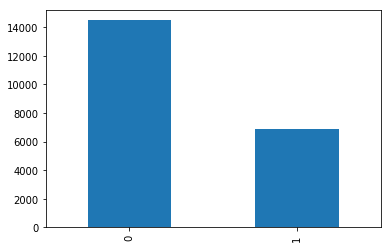

In [6]:
# Let's see how many examples we have of each class
df["removed"].value_counts().plot.bar()

In [9]:
x = df["body"].values
y = df["removed"].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True)

In [8]:
# Clean the text
clean_text_transformer = CleanTextTransformer()
x_train_clean = clean_text_transformer.transform(x_train)

In [9]:
# Tokenize the text and get the lemmas
spacy_tokenizer = SpacyTokenTransformer()
x_train_tokenized = spacy_tokenizer.transform(x_train_clean)

In [10]:
# Build tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    preprocessor=lambda x: x, 
    tokenizer=lambda x: x, 
    token_pattern=None,
    ngram_range=(1, 3))

tfidf_vectorizer.fit(x_train_tokenized)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<function <lambda> at 0x7fce08047378>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern=None,
        tokenizer=<function <lambda> at 0x7fce080472f0>, use_idf=True,
        vocabulary=None)

In [12]:
# Transform our tokens to tfidf vectors
x_train_tfidf = tfidf_vectorizer.transform(
    x_train_tokenized)

In [13]:
# Train logistic regression classifier
lr = LogisticRegression(C=0.1, solver='sag')
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
# These are the models we'll deploy
with open('tfidf_vectorizer.model', 'wb') as model_file:
    dill.dump(tfidf_vectorizer, model_file)
with open('lr.model', 'wb') as model_file:
    dill.dump(lr, model_file)

In [15]:
# This is the class we will use to deploy
!cat RedditClassifier.py

import dill

from ml_utils import CleanTextTransformer, SpacyTokenTransformer

class RedditClassifier(object):
    def __init__(self):
        
        self._clean_text_transformer = CleanTextTransformer()
        self._spacy_tokenizer = SpacyTokenTransformer()
        
        with open('tfidf_vectorizer.model', 'rb') as model_file:
            self._tfidf_vectorizer = dill.load(model_file)
           
        with open('lr.model', 'rb') as model_file:
            self._lr_model = dill.load(model_file)

    def predict(self, X, feature_names):
        clean_text = self._clean_text_transformer.transform(X)
        spacy_tokens = self._spacy_tokenizer.transform(clean_text)
        tfidf_features = self._tfidf_vectorizer.transform(spacy_tokens)
        predictions = self._lr_model.predict_proba(tfidf_features)
        return predictions



In [10]:
# test that our model works
from RedditClassifier import RedditClassifier
# With one sample
sample = x_test[0:1]
print(sample)
print(RedditClassifier().predict(sample, ["feature_name"]))

['This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf']
[[0.82767056 0.17232944]]


# Create Docker Image
Using the S2I command line interface we wrap our current model to seve it through the Seldon interface

In [17]:
# To create a docker image we need to create the .s2i folder configuration as below:
!cat .s2i/environment

MODEL_NAME=RedditClassifier
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


In [18]:
# As well as a requirements.txt file with all the relevant dependencies
!cat requirements.txt

scipy>= 0.13.3
scikit-learn>=0.18
spacy==2.0.18
dill==0.2.9


In [19]:
!s2i build . seldonio/seldon-core-s2i-python3:0.6 reddit-classifier:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Stored in directory: /root/.cache/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Stored in directory: /root/.cache/pip/wheels/74/17/3f/c77bba99efd74ba1a19862c9dd97f4b6d735e2826721dc00ff


Stored in directory: /root/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Stored in directory: /root/.cache/pip/wheels/88/f3/11/9817b001e59ab04889e8cffcbd9087e2e2155b9ebecfc8dd38
Stored in directory: /root/.cache/pip/wheels/f4/0c/f6/ce6b2d1aa459ee97cc3c0f82236302bd62d89c86c700219463
Successfully built dill ujson regex wrapt cytoolz toolz
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


In [31]:
# Remove previously deployed containers for this model
!docker rm -f reddit_predictor

reddit_predictor


In [75]:
!docker run --name "reddit_predictor" -d --rm -p 5001:5000 reddit-classifier:0.1

812a02932fb6d61eb90727f99df051a67720a14de59504bbd808f1159fcda65e


In [26]:
# Here we need to wait until we see "Linking successful", as it's downloading the Spacy English model
# You can hit stop when this happens
!docker logs -t -f reddit_predictor

2019-05-21T05:18:10.089008100Z starting microservice
2019-05-21T05:18:11.567254000Z 2019-05-21 05:18:11,566 - seldon_core.microservice:main:154 - INFO:  Starting microservice.py:main
2019-05-21T05:18:11.568744400Z 2019-05-21 05:18:11,568 - seldon_core.microservice:main:185 - INFO:  Annotations: {}
2019-05-21T05:18:12.629109700Z Collecting en_core_web_sm==2.0.0 from https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz#egg=en_core_web_sm==2.0.0
2019-05-21T05:18:13.675815500Z   Downloading https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz (37.4MB)
2019-05-21T05:18:22.124982300Z Building wheels for collected packages: en-core-web-sm
2019-05-21T05:18:22.125493500Z   Building wheel for en-core-web-sm (setup.py): started
2019-05-21T05:18:24.199642200Z   Building wheel for en-core-web-sm (setup.py): finished with status 'done'
2019-05-21T05:18:24.199964600Z   Stored in directory: 

In [37]:
# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5000"
batch = sample
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)
response = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

print(response)

Success:True message:
Request:
data {
  names: "tfidf"
  ndarray {
    values {
      string_value: "This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf"
    }
  }
}

Response:
meta {
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.8276705633548711
        }
        values {
          number_value: 0.17232943664512895
        }
      }
    }
  }
}



In [38]:
# We now stop it to run it in docker
!docker stop reddit_predictor

reddit_predictor


# Run in kubernetes cluster

In [42]:
# Make sure that seldon is running 
!kubectl get pods 

NAME                                                  READY   STATUS    RESTARTS   AGE
seldon-core-redis-master-0                            1/1     Running   0          59s
seldon-core-seldon-apiserver-d8fd4cd68-5mzzt          1/1     Running   0          59s
seldon-core-seldon-cluster-manager-67c64974b6-d8cfb   1/1     Running   0          59s


In [ ]:
# If not running you can install it
# First initialise helm
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default
!helm init
!kubectl rollout status deploy/tiller-deploy -n kube-system

In [ ]:
# Then install and run seldon
helm install seldon-core-crd --name seldon-core-crd --repo https://storage.googleapis.com/seldon-charts
helm install seldon-core --name seldon-core --repo https://storage.googleapis.com/seldon-charts 

In [39]:
# We'll use our seldon deployment file
!cat reddit_clf.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "reddit-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Reddit classifier",
            "deployment_version": "v1"
        },
        "name": "reddit-classifier",
        "oauth_key": "oauth-key",
        "oauth_secret": "oauth-secret",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "reddit-classifier:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                          

In [43]:
!kubectl apply -f reddit_clf.json

seldondeployment.machinelearning.seldon.io/reddit-classifier created


In [45]:
!kubectl get pods 

NAME                                                      READY   STATUS    RESTARTS   AGE
reddit-classifier-single-model-9199e4b-5c49c85c7d-mjvrh   2/2     Running   0          62s
seldon-core-redis-master-0                                1/1     Running   0          2m14s
seldon-core-seldon-apiserver-d8fd4cd68-5mzzt              1/1     Running   0          2m14s
seldon-core-seldon-cluster-manager-67c64974b6-d8cfb       1/1     Running   0          2m14s


In [19]:
!echo `kubectl get svc -l app=seldon-apiserver-container-app -o jsonpath='{.items[0].spec.ports[0].nodePort}'`

31203


In [24]:
host = "localhost"
port = "31203" # Make sure you use the port above
batch = sample
payload_type = "ndarray"

sc = SeldonClient(gateway="seldon", seldon_rest_endpoint=host + ":" + port,
                          oauth_key="oauth-key", oauth_secret="oauth-secret")
response = sc.predict(
    data=batch, 
    deployment_name="mymodel",
    names=["text"],
    payload_type=payload_type)

print(response)

WORKS!!!!
Success:True message:
Request:
data {
  names: "text"
  ndarray {
    values {
      string_value: "This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf"
    }
  }
}

Response:
meta {
  puid: "9359cpdudo3b6i6cv82ktsl4pe"
  requestPath {
    key: "classifier"
    value: "reddit-classifier:0.1"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.8276705633548711
        }
        values {
          number_value: 0.17232943664512895
        }
      }
    }
  }
}

